<a href="https://colab.research.google.com/github/mddsayemm/Precision-Farming/blob/main/SugarweedTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-1-da5e0677cdcd>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Image: /content/drive/MyDrive/test/dji-58-image-015_337.jpg, Predicted Class: weed
Image: /content/drive/MyDrive/test/dji-58-image-013_1.jpg, Predicted Class: weed
Image: /content/drive/MyDrive/test/dji-58-image-005_2957.jpg, Predicted Class: weed
Image: /content/drive/MyDrive/test/dji-57-image-129_420.jpg, Predicted Class: weed
Image: /content/drive/MyDrive/test/dji-57-image-127_40.jpg, Predicted Class: weed
Image: /content/drive/MyDrive/test/dji-58-image-011_1437.jpg, Predicted Class: weed
Image: /content/drive/MyDrive/test/dji-58-image-012_1668.jpg, Predicted Class: weed
Image: /content/drive/MyDrive/test/dji-58-image-005_3.jpg, Predicted Class: weed
Image: /content/drive/MyDrive/test/dji-58-image-007_2.jpg, Predicted Class: weed
Image: /content/drive/MyDrive/test/dji-64-image-318_37.jpg, Predicted Class: sugar beet
Image: /content/drive/MyDrive/test/dji-64-image-318_47.jpg, Predicted Class: sugar beet
Image: /content/drive/MyDrive/test/dji-64-image-319_1.jpg, Predicted Class: sugar

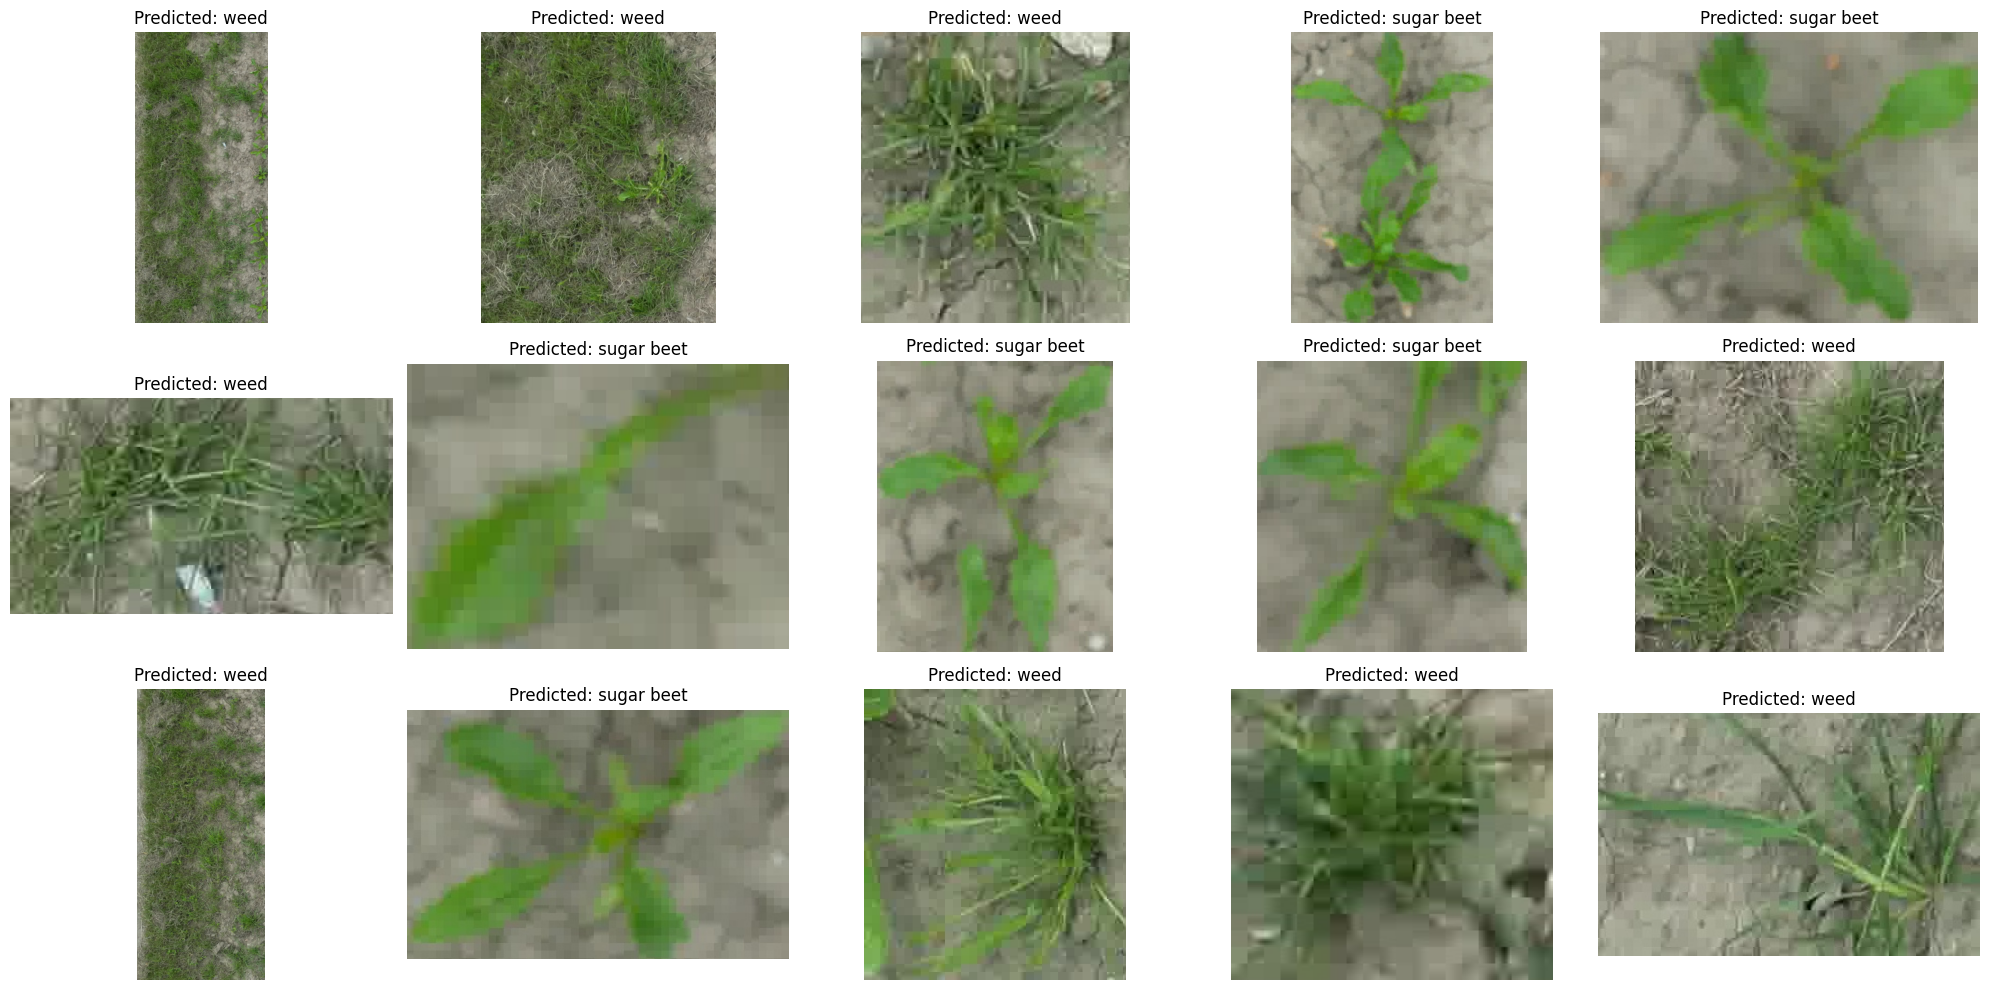

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to binary classification dataset
dataset_path = "/content/drive/MyDrive/test"

# Ensure the dataset folder exists
assert os.path.exists(dataset_path), "Dataset folder does not exist!"

# Custom Dataset for Binary Classification
class CustomImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = [
            os.path.join(folder_path, fname)
            for fname in os.listdir(folder_path)
            if fname.lower().endswith(('jpg', 'jpeg', 'png'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, image_path

# Data transformations (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create the custom dataset
test_dataset = CustomImageDataset(dataset_path, transform=transform)

# Create a DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class names for binary classification
class_names = ['sugar beet', 'weed']  # Confidence 0 = sugar beet, Confidence 1 = weed

# Load the trained ResNet-18 model
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Binary classification (output = 1)
model = model.to(device)

# Load the saved model weights
model_path = "/content/drive/MyDrive/resnet18_no_pretrained.pth"  # Update with your saved model path
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Function to perform inference on the dataset
def evaluate_model_with_names(model, data_loader, device):
    predictions = []
    image_paths = []

    with torch.no_grad():
        for inputs, paths in tqdm(data_loader, desc="Testing Progress"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).long()  # Convert logits to binary predictions
            predictions.extend(preds.cpu().numpy().flatten())
            image_paths.extend(paths)

    return predictions, image_paths

# Evaluate the model on the test dataset
predictions, image_paths = evaluate_model_with_names(model, test_loader, device)

# Print results with class names
for img_path, pred in zip(image_paths, predictions):
    print(f"Image: {img_path}, Predicted Class: {class_names[pred]}")

# Visualize 15 random images with their predictions
def visualize_predictions(image_paths, predictions, class_names, num_images=15):
    plt.figure(figsize=(20, 10))

    # Select 15 random images
    indices = random.sample(range(len(image_paths)), min(num_images, len(image_paths)))

    for i, idx in enumerate(indices):
        img_path = image_paths[idx]
        pred_class = class_names[predictions[idx]]

        # Load and plot the image
        img = Image.open(img_path).convert("RGB")
        plt.subplot(3, 5, i + 1)  # 3 rows, 5 columns
        plt.imshow(img)
        plt.title(f"Predicted: {pred_class}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_predictions(image_paths, predictions, class_names)
